In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import json
import io

## Variables

In [2]:
prof_runs = ['de6349d','a94c677']
# the string in this pattern are entries from the prof_runs list
prof_file_pattern = "spacetime_%s.json"

# Entry name (e.g., region or kernel name) that is used as root for viz.
# In other words, only regions/parallel fors/... that have this region as
# parent will be processed.
root_name = 'MultiStage_Step'

# Object name of the region/parallel_for/... that is used for normalization,
# i.e., all timing will be plotted relative to this object.
# This needs to be a child of the root object (i.e., have the root object as parent)
reference_name = 'Task_Advection_CalculateFluxes'

# filter function (currenlty by name, that is used to only show a filtered selection of object)
def exclude_object(this_name) -> bool:
    # keep all regions with Task in the name
    if 'Task' in this_name:
        return False
    # FluxDivergenceMesh is effectively a task but given the brief
    # implementation in Parthenon (simple kernel without bells and whistles around)
    # is not surrouned by a separated "Task_" region and thus to be explicitly
    # included here.
    if'FluxDiv' in this_name:
        return False
    return True

## Read and process data

In [3]:
# dict holding all processed data for plotting
# will look like:
#   plot_data[kernel/region name][prof_run] = time
plot_data = {}
# holds the timing data for the "root" region (later used for normalization)
root_time = {}

for prof_run in prof_runs:
    #######################
    # (Temporary) fix for quotation marks ('""') issue in kernel naming as 
    # they are currently not escaped when writing json output from the
    # Kokkos profiling library.
    # This should be fixed soon.
    fname = prof_file_pattern % prof_run

    with open(fname) as file_in:

        output = io.StringIO()
        for line in file_in.readlines():
            # a problematic line may look like
            # "name" : ""recv buf 20"="send buf 16"",
            if '""' in line:
                first = line.index('""') + 1
                last = -line[::-1].index('""') - 1
                # escape all quotation marks within the value of the entry
                line = line[:first] + line[first:last].replace('"','\\"') + line[last:]

            output.write(line)
    #### end of temp fix
    # now load the "fixed" json data directly as string stream
    data = json.loads(output.getvalue())['space-time-stack-data']
    
    # find root object
    for obj in data:
        if obj['name'] == root_name:

            #print(obj)
            root_id = obj['id']
            root_time[prof_run] = float(obj['average-time'])
            break

    
    # find all child objects
    for obj in data:
        if obj['parent-id'] == root_id:
            this_name = obj['name']
            if exclude_object(this_name):
                continue
            
            if this_name not in plot_data.keys():
                plot_data[this_name] = {}
            plot_data[this_name][prof_run] = float(obj['average-time'])
        


## Comparison of regions/kernels side by side for multiple data

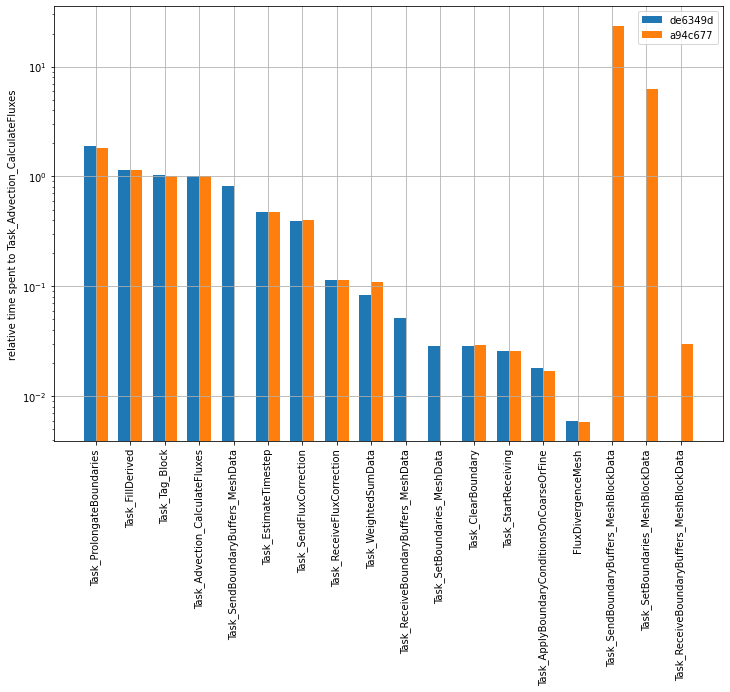

In [4]:
fig, ax = plt.subplots(figsize=(12,8))

# collect labels for x axis (kernels/regions)
labels = []
for region in plot_data.keys():    
    labels.append(region)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

for i, prof_run in enumerate(prof_runs):
    y = []
    for region in plot_data.keys():
        # not all regions/kernels may be in every json file, e.g., if a new feature
        # introduce
        if prof_run not in plot_data[region].keys():
            y.append(0)
        else:
            y.append(plot_data[region][prof_run]/plot_data[reference_name][prof_run])
    ax.bar(x - width/2 + i*width, y, width, label=prof_run)
        

ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.grid()
ax.set_ylabel('relative time spent to ' + reference_name)
ax.legend()
#plt.plot(y)
#plt.xticks(x, labels, rotation='vertical')

## Pie chart highlighting relative fraction of time for a single data file

Edit cell below to adjust plotted data

In [5]:
# Run to plot. Each pie chart only contains data for one data source.
prof_run = 'de6349d'

# edit below as needed depending on regions of interest
def is_infrastructure(this_name) -> bool:
    """ separate infrastructure from application regions/kernels
    """
    if 'FillDerived' in this_name:
        return False
    if 'Advection' in this_name:
        return False
    if 'Timestep' in this_name:
        return False
    if 'WeightedSumData' in this_name:
        return False
    if 'FluxDivergence' in this_name:
        return False
    return True

In [6]:
# Process (i.e., separate) the data for plotting.
# We want to highlight infrastructure and application separately and,
# thus, process the data separately.

time_app = []
labels_app = []
time_inf = []
labels_inf = []

for region in plot_data.keys():
    if exclude_object(region):
        continue
    # not all regions/kernels may be in every json file,
    # e.g., if a new feature is introduced
    if prof_run not in plot_data[region].keys():
        this_time = 0
    else:
        # normalize time to percentage of parent region
        this_time = plot_data[region][prof_run]/root_time[prof_run]*100
    
    if is_infrastructure(region):
        time_inf.append(this_time)
        labels_inf.append(region)
        
    else:
        time_app.append(this_time)
        labels_app.append(region)
        
# combine normalized time with labels and sort by time
app = sorted(zip(time_app, labels_app))
inf = sorted(zip(time_inf, labels_inf))

# add time for all "other" parts that were not explicitly profiled
other = [(100-float(np.sum(time_app) + np.sum(time_inf)), 'Other')]


all_pie_data_with_labels = np.array(app + inf + other)

# create a joint colormap for all data points to plot
# infrastructure will be plotted in shades of blue and application regions in shades of orange
cmap = np.concatenate((plt.get_cmap("Blues")(np.arange(len(time_inf))/len(time_inf)),
                      plt.get_cmap("Oranges")(np.arange(len(time_app))/len(time_app)),
                      [[0.,0.,0.,1.]]), # black color for "other"
                      axis = 0)
                                              
         

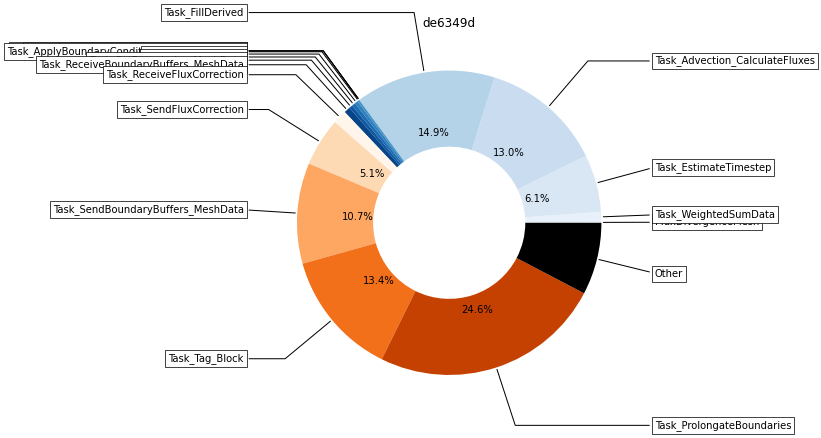

In [7]:
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(aspect="equal"))


labels = [label for time, label in all_pie_data_with_labels]
data = np.array([time for time, label in all_pie_data_with_labels])

# only print percentage if larger than 3%
def plot_percentage(pct):
    if pct > 3.:
        return r"{:.1f}%".format(pct)
    else:
        return ""


wedges, texts, autotexts = ax.pie(data, wedgeprops=dict(width=0.5),
                                  startangle=0, colors=cmap,
                                  autopct=plot_percentage,
                                 )

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)


ax.set_title(prof_run)

plt.show()